In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
import calendar
from sklearn.linear_model import LinearRegression
import scipy.signal as signal
from scipy.stats import norm
import seaborn as sns

In [2]:
import matplotlib.backends.backend_pdf
pdf = matplotlib.backends.backend_pdf.PdfPages("peso.pdf")

In [3]:
df = pd.read_csv("./data/SWT_EXPORT_12_16_20_23_22.csv",
                 parse_dates=["Date"],
                 dtype={"Date":"str", "Weight":"float"})
df=df.drop_duplicates()

In [4]:
df["Year"] = pd.DatetimeIndex(df["Date"]).year
df["Month"] = pd.DatetimeIndex(df["Date"]).month
df["Day"] = pd.DatetimeIndex(df["Date"]).day
df["Week"] = pd.DatetimeIndex(df["Date"]).week
df["DayOfWeek"] = pd.DatetimeIndex(df["Date"]).dayofweek
df["ref_day_year"] = pd.to_datetime(df["Year"].map('{:04}-07-01'.format), format='%Y-%m-%d')
df["ref_day_month"] = pd.to_datetime(df["Year"].map('{:04}'.format) + "-" 
                                 + df["Month"].map('{:02}'.format) + "-15", format='%Y-%m-%d')
df["ref_day_week"] = df["Year"].map('{:04}'.format) + "-W" + df["Week"].map('{:02}'.format) + "-04"
df["ref_day_week"] = df["ref_day_week"].apply(lambda x: datetime.datetime.strptime(x, '%Y-W%W-0%w'))
df["ref_day_week"] = pd.to_datetime(df["ref_day_week"], format='%Y-%m-%d')

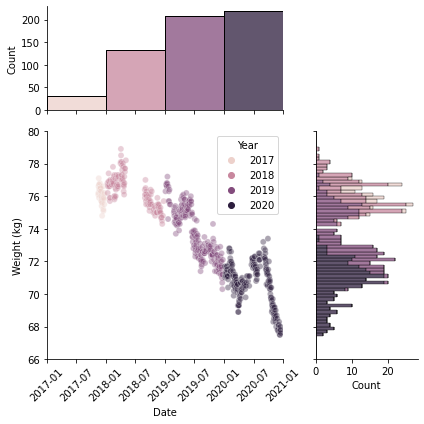

In [5]:
pmin, pmax, nbins = (66,80,70)
xbins=np.linspace(pmin,pmax,nbins+1)
ybins=["2017-01-01","2018-01-01","2019-01-01","2020-01-01","2021-01-01"]
ybins=mdates.date2num(ybins)
g = sns.JointGrid(data=df,
    x="Date",
    y="Weight",
    hue="Year",
    xlim=(ybins[0],ybins[-1]),
    ylim=(pmin,pmax),
    marginal_ticks=True,
    height=6, 
    ratio=2, 
    space=.05)
g.plot_joint(sns.scatterplot, 
        alpha=.4,
        legend=True)
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("Weight (kg)")
sns.histplot(data=df, x="Date", hue="Year", bins=ybins, ax=g.ax_marg_x, legend=False, multiple='stack')
sns.histplot(data=df, y="Weight", hue="Year", bins=xbins, ax=g.ax_marg_y, legend=False, multiple='stack')
plt.tight_layout()
plt.show()
pdf.savefig(g.fig)

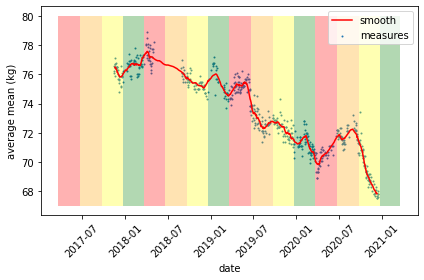

In [6]:
nmeas = 10
weight_dict = {"Weight":[], "Date":[]}
for idx in df.index:
    sub = df[(df.index > idx - nmeas) & (df.index < idx + nmeas)]
    weight_dict["Weight"].append(sub["Weight"].mean())
    weight_dict["Date"].append(min(sub["Date"]) + (sub["Date"] - min(sub["Date"])).mean())
smooth_weight = pd.DataFrame()
smooth_weight["Weight"] = weight_dict["Weight"]
smooth_weight["Date"] = weight_dict["Date"]
fig, ax = plt.subplots()
plt.scatter(x=df["Date"],y=df["Weight"],label="measures",s=1)
plt.plot(smooth_weight["Date"],smooth_weight["Weight"],color="red",label="smooth")
seasons = {}
ymin, ymax = 2017, 2021
for y in range(ymin,ymax):
    seasons[y] = {
        "spring": {
            "date": [datetime.datetime.strptime("{}-03-20".format(y),"%Y-%m-%d"),
                     datetime.datetime.strptime("{}-06-21".format(y),"%Y-%m-%d")],
            "color":"red"},
        "summer": {
            "date": [datetime.datetime.strptime("{}-06-21".format(y),"%Y-%m-%d"),
                     datetime.datetime.strptime("{}-09-22".format(y),"%Y-%m-%d")],
            "color":"orange"},
        "fall"  : {
            "date": [datetime.datetime.strptime("{}-09-22".format(y),"%Y-%m-%d"),
                     datetime.datetime.strptime("{}-12-21".format(y),"%Y-%m-%d")],
            "color":"yellow"},
        "winter": {
            "date": [datetime.datetime.strptime("{}-12-21".format(y),"%Y-%m-%d"),
                     datetime.datetime.strptime("{}-03-20".format(y+1),"%Y-%m-%d")],
            "color":"green"}
    }
for y in seasons:
    for s in seasons[y]:
        plt.fill_between(seasons[y][s]["date"], 67, 80, facecolor=seasons[y][s]["color"], alpha=0.3)
plt.ylabel("average mean (kg)")
plt.xlabel("date")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()
pdf.savefig(fig)

In [7]:
x = df["Date"].astype(int)/(1.E9*60*60*24)
y = df.iloc[:,1]
f = 10**np.linspace(np.log10(1/400), np.log10(1/5), 100000)
pgram = signal.lombscargle(x, y, f, normalize=False)

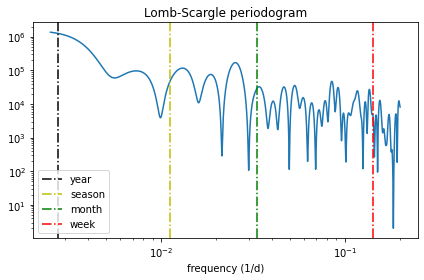

In [8]:
fig, ax = plt.subplots()
plt.plot(f, pgram)
plt.axvline(x=1/365, color='black', label="year",linestyle='-.')
plt.axvline(x=1/90, color='y', label="season",linestyle='-.')
plt.axvline(x=1/30, color='g', label="month",linestyle='-.')
plt.axvline(x=1/7, color='r', label="week",linestyle='-.')
plt.yscale("log")
plt.xscale("log")
plt.xlabel("frequency (1/d)")
plt.title("Lomb-Scargle periodogram")
plt.legend()
plt.tight_layout()
plt.show()
pdf.savefig(fig)

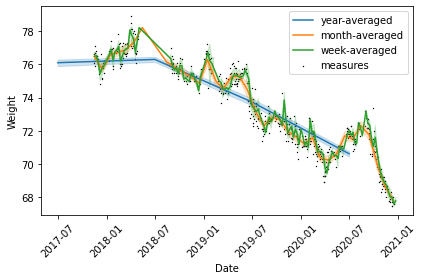

In [9]:
fig = plt.figure()
sns.scatterplot(data=df,x="Date",y="Weight",label="measures",s=2,color="black")
sns.lineplot(data=df,x="ref_day_year",y="Weight",label="year-averaged")
sns.lineplot(data=df,x="ref_day_month",y="Weight",label="month-averaged")
sns.lineplot(data=df,x="ref_day_week",y="Weight",label="week-averaged")
plt.xticks(rotation=45)
plt.tight_layout()
pdf.savefig(fig)

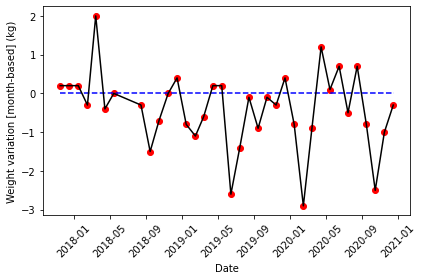

In [10]:
df_max=df[["Year","Month","Date"]].groupby(["Year","Month"]).max()
df_min=df[["Year","Month","Date"]].groupby(["Year","Month"]).min()
df_max=df_max.reset_index()
df_min=df_min.reset_index()
df_minmax=df_max.merge(df[["Date","Weight"]],how="left",on=["Date"],validate="1:1")
df_minmax=df_minmax.merge(df_min,how="left",on=["Year","Month"],validate="1:1")
df_minmax=df_minmax.merge(df[["Date","Weight"]],how="left",left_on=["Date_y"],right_on=["Date"],validate="1:1")
df_minmax.rename(columns={'Date_x': 'Date_max', 'Weight_x': 'Weight_max',
                            'Date_y': 'Date_min', 'Weight_y': 'Weight_min'}, inplace=True)
df_minmax["dw"]=df_minmax["Weight_max"]-df_minmax["Weight_min"]
df_minmax["Date_ref"] = pd.to_datetime(df_minmax["Year"].map('{:04}'.format) + "-" 
                                 + df_minmax["Month"].map('{:02}'.format) + "-15", format='%Y-%m-%d')
fig, ax = plt.subplots()
plt.plot(df_minmax["Date_ref"],df_minmax["dw"],color="black")
plt.scatter(df_minmax["Date_ref"],df_minmax["dw"],color="r")
plt.xticks(rotation=45)
plt.hlines(0., min(df_minmax["Date_min"]), max(df_minmax["Date_max"]), colors='b', linestyles='--')
plt.xlabel("Date")
plt.ylabel("Weight variation [month-based] (kg)")
plt.tight_layout()
plt.show()
pdf.savefig(fig)

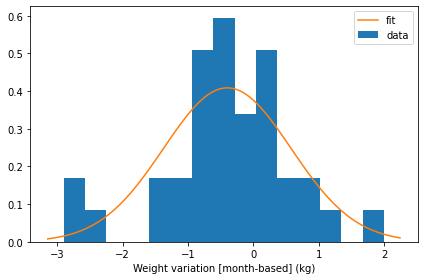

mean: -0.40, std: 0.98


In [11]:
fig, ax = plt.subplots()
plt.hist(df_minmax["dw"],bins=15,density=True,label="data")
mean,std=norm.fit(df_minmax["dw"])
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
y = norm.pdf(x, mean, std)
plt.plot(x, y,label="fit")
plt.legend()
plt.xlabel("Weight variation [month-based] (kg)")
plt.tight_layout()
plt.show()
pdf.savefig(fig)
print(f"mean: {mean:.2f}, std: {std:.2f}")

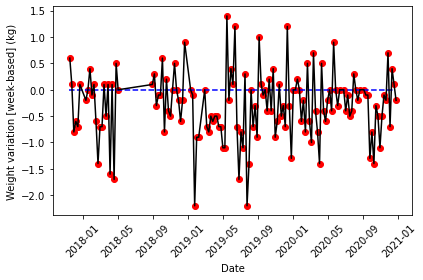

In [12]:
df_max=df[["Year","Week","Date"]].groupby(["Year","Week"]).max()
df_min=df[["Year","Week","Date"]].groupby(["Year","Week"]).min()
df_max=df_max.reset_index()
df_min=df_min.reset_index()
df_minmax=df_max.merge(df[["Date","Weight"]],how="left",on=["Date"],validate="1:1")
df_minmax=df_minmax.merge(df_min,how="left",on=["Year","Week"],validate="1:1")
df_minmax=df_minmax.merge(df[["Date","Weight"]],how="left",left_on=["Date_y"],right_on=["Date"],validate="1:1")
df_minmax.rename(columns={'Date_x': 'Date_max', 'Weight_x': 'Weight_max',
                            'Date_y': 'Date_min', 'Weight_y': 'Weight_min'}, inplace=True)
df_minmax["dw"]=df_minmax["Weight_max"]-df_minmax["Weight_min"]
df_minmax["Date_ref"] = df_minmax["Year"].map('{:04}'.format) + \
                "-W" + df_minmax["Week"].map('{:02}'.format) + "-04"
df_minmax["Date_ref"] = df_minmax["Date_ref"].apply(lambda x: datetime.datetime.strptime(x, '%Y-W%W-0%w'))
fig, ax = plt.subplots()
plt.plot(df_minmax["Date_ref"],df_minmax["dw"],color="black")
plt.scatter(df_minmax["Date_ref"],df_minmax["dw"],color="r")
plt.xticks(rotation=45)
plt.hlines(0., min(df_minmax["Date_min"]), max(df_minmax["Date_max"]), colors='b', linestyles='--')
plt.xlabel("Date")
plt.ylabel("Weight variation [week-based] (kg)")
plt.tight_layout()
plt.show()
pdf.savefig(fig)

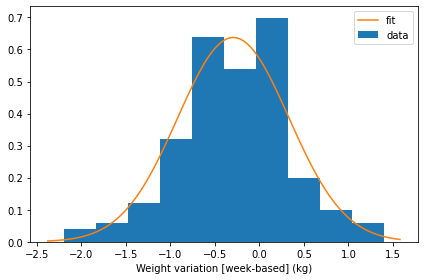

mean: -0.29, std: 0.63


In [13]:
fig, ax = plt.subplots()
plt.hist(df_minmax["dw"],bins=10,density=True,label="data")
mean,std=norm.fit(df_minmax["dw"])
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
y = norm.pdf(x, mean, std)
plt.plot(x, y,label="fit")
plt.legend()
plt.xlabel("Weight variation [week-based] (kg)")
plt.tight_layout()
plt.show()
pdf.savefig(fig)
print(f"mean: {mean:.2f}, std: {std:.2f}")

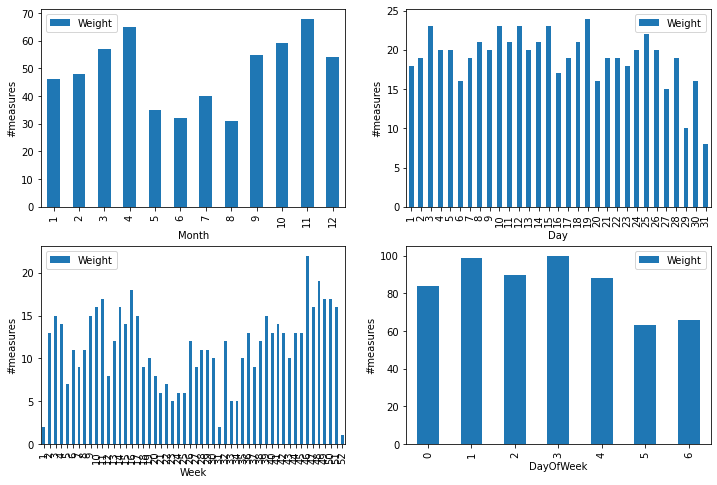

In [14]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(ncols=2,nrows=2,figsize=[12, 8])
df[["Month","Weight"]].groupby(["Month"]).count().plot.bar(ax=ax1)
ax1.set_ylabel("#measures")
df[["Day","Weight"]].groupby(["Day"]).count().plot.bar(ax=ax2)
ax2.set_ylabel("#measures")
df[["Week","Weight"]].groupby(["Week"]).count().plot.bar(ax=ax3)
ax3.set_ylabel("#measures")
df[["DayOfWeek","Weight"]].groupby(["DayOfWeek"]).count().plot.bar(ax=ax4)
ax4.set_ylabel("#measures")
plt.show()
pdf.savefig(fig)

In [15]:
df_year = df[["Year","Weight"]].groupby(["Year"]).count()
df_year.columns = ["count"]
df_year["mean"] = df[["Year","Weight"]].groupby(["Year"]).mean()
df_year["var"] = df[["Year","Weight"]].groupby(["Year"]).var()
df_year["std"] = df[["Year","Weight"]].groupby(["Year"]).std()
df_year = df_year.reset_index()
df_year["Date"] = pd.to_datetime(df_year["Year"].map('{:04}-07-01'.format), format='%Y-%m-%d')

In [16]:
df_month = df[["Year","Month","Weight"]].groupby(["Year","Month"]).count()
df_month.columns = ["count"]
df_month["mean"] = df[["Year","Month","Weight"]].groupby(["Year","Month"]).mean()
df_month["var"] = df[["Year","Month","Weight"]].groupby(["Year","Month"]).var()
df_month["std"] = df[["Year","Month","Weight"]].groupby(["Year","Month"]).std()
df_month = df_month.reset_index()
df_month["YearMonth"] = df_month["Year"].map('{:04}'.format) + "-" +df_month["Month"].map('{:02}'.format)
df_month["Date"] = pd.to_datetime(df_month["Year"].map('{:04}'.format) + "-" 
                                 + df_month["Month"].map('{:02}'.format) + "-15", format='%Y-%m-%d')

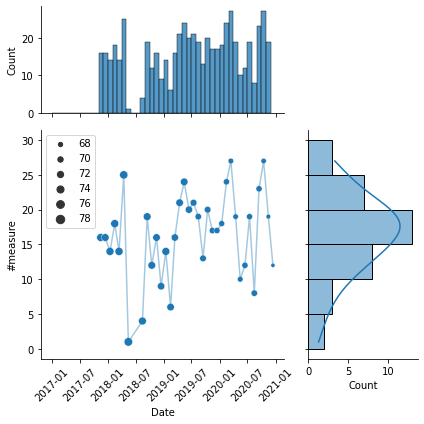

In [17]:
years=[[f"{y}-{m:02d}-01" for m in range(1,13)] for y in range(2017,2021)]
ybins=[]
for y in years:
    ybins = ybins + y
ybins=mdates.date2num(ybins)
g = sns.JointGrid(data=df_month,
    x="Date",
    y="count",
    marginal_ticks=True,
    height=6, 
    ratio=2, 
    space=.05)
g.plot_joint(sns.scatterplot, 
        size=df_month["mean"],
        legend=True)
g.plot_joint(sns.lineplot,
        alpha=.4)
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("#measure")
sns.histplot(data=df_month, x="Date", bins=ybins, ax=g.ax_marg_x, legend=False, multiple='stack',weights=df_month["count"])
sns.histplot(data=df_month, y="count", bins=range(0,35,5), ax=g.ax_marg_y, legend=False, multiple='stack',kde=True)
plt.tight_layout()
plt.show()
pdf.savefig(g.fig)

In [18]:
df_week = df[["Year","Week","Weight"]].groupby(["Year","Week"]).count()
df_week.columns = ["count"]
df_week["mean"] = df[["Year","Week","Weight"]].groupby(["Year","Week"]).mean()
df_week["var"] = df[["Year","Week","Weight"]].groupby(["Year","Week"]).var()
df_week["std"] = df[["Year","Week","Weight"]].groupby(["Year","Week"]).std()
df_week = df_week.reset_index()
df_week["YearWeek"] = df_week["Year"].map('{:04}'.format) + "-" +df_week["Week"].map('{:02}'.format)
df_week["Date"] = df_week["Year"].map('{:04}'.format) + "-W" + df_week["Week"].map('{:02}'.format) + "-04"
df_week["Date"] = df_week["Date"].apply(lambda x: datetime.datetime.strptime(x, '%Y-W%W-0%w'))
df_week["Date"] = pd.to_datetime(df_week["Date"], format='%Y-%m-%d')

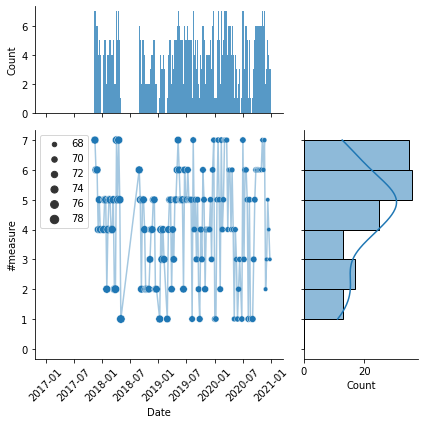

In [19]:
years=[[datetime.datetime.strptime(f"{y}-W{w:02d}-01","%Y-W%W-0%w") for w in range(1,54)] for y in range(2017,2021)]
ybins=[]
for y in years:
    ybins = ybins + y
ybins=mdates.date2num(ybins)
g = sns.JointGrid(data=df_week,
    x="Date",
    y="count",
    marginal_ticks=True,
    height=6, 
    ratio=2, 
    space=.05)
g.plot_joint(sns.scatterplot, 
        size=df_week["mean"],
        legend=True)
g.plot_joint(sns.lineplot,
        alpha=.4)
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("#measure")
sns.histplot(data=df_week, x="Date", bins=ybins, ax=g.ax_marg_x, legend=False, multiple='stack',weights=df_week["count"])
sns.histplot(data=df_week, y="count", bins=range(8), ax=g.ax_marg_y, legend=False, multiple='stack',kde=True)
plt.tight_layout()
plt.show()
pdf.savefig(g.fig)

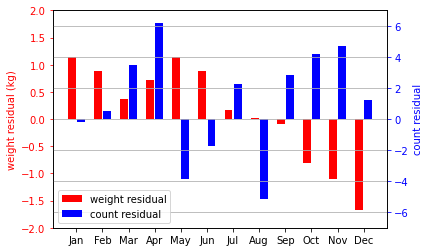

In [20]:
df_yearmonth_weight = pd.merge(df_month[["Year","Month","mean"]].rename(columns={"mean":"mean_month"}),
                        df_year[["Year","mean"]].rename(columns={"mean":"mean_year"}),
                        how='left',on="Year",validate="m:1")
df_yearmonth_weight["residual"] = df_yearmonth_weight["mean_month"] - df_yearmonth_weight["mean_year"]
df_yearmonth_weight=df_yearmonth_weight[["Month","residual"]].groupby(["Month"]).mean()
df_yearmonth_weight=df_yearmonth_weight.reset_index()
df_yearmonth_count = pd.merge(df_month[["Year","Month","count"]].rename(columns={"count":"count_month"}),
                        df_year[["Year","count"]].rename(columns={"count":"count_year"}),
                        how='left',on="Year",validate="m:1")
df_yearmonth_count["residual"] = df_yearmonth_count["count_month"] - df_yearmonth_count["count_year"]/12.
df_yearmonth_count=df_yearmonth_count[["Month","residual"]].groupby(["Month"]).mean()
df_yearmonth_count=df_yearmonth_count.reset_index()
width=0.35
fig, ax = plt.subplots()
ax2 = ax.twinx()
plot1 = ax.bar(df_yearmonth_weight["Month"]-0.5*width,
    df_yearmonth_weight["residual"],
    width-0.05,
    color="r")
plot2 = ax2.bar(df_yearmonth_count["Month"]+0.5*width,
    df_yearmonth_count["residual"],
    width-0.05,
    color="b")
ax.set_ylim(-2,2)
ax2.set_ylim(-7, 7)
ax.set_ylabel('weight residual (kg)')
ax2.set_ylabel('count residual')
ax.tick_params(axis='y', colors='red')
ax.yaxis.label.set_color('red')
ax2.tick_params(axis='y', colors='blue')
ax2.yaxis.label.set_color('blue')
plt.xlabel("")
plt.xticks(range(1,13),[calendar.month_name[x][0:3] for x in range(1,13)],rotation=0)
plt.legend((plot1,plot2),("weight residual","count residual"))
plt.grid(True)
plt.show()
pdf.savefig(fig)

In [21]:
df_yearmonth = pd.merge(df_yearmonth_weight[["Month","residual"]].rename(columns={"residual":"res_weight"}).groupby(["Month"]).mean(), df_yearmonth_count[["Month","residual"]].rename(columns={"residual":"res_count"}).groupby(["Month"]).mean(), on="Month",validate="1:1")

In [22]:
model_ym = LinearRegression()
x = df_yearmonth.iloc[:, 0].values.reshape(-1, 1)
y = df_yearmonth.iloc[:, 1].values.reshape(-1, 1)
l = df_yearmonth.index
model_ym.fit(x,y)
fy = model_ym.predict(x)

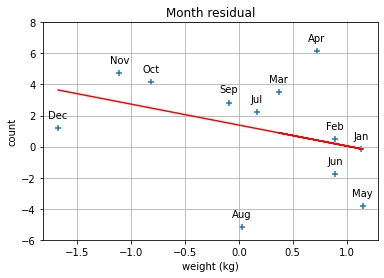

In [23]:
fig, ax = plt.subplots()
plt.scatter(x,y,marker="+")
plt.plot(x, fy, color='red')
plt.title("Month residual")
plt.ylabel("count")
plt.xlabel("weight (kg)")
plt.ylim(-6,8)
for xv,yv,lv in zip(x,y,l):
    plt.annotate(calendar.month_name[lv][0:3], # this is the text
                 (xv,yv), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.grid(True)
plt.show()
pdf.savefig(fig)

In [24]:
df_yearmonth.corr(method='pearson')

,res_weight,res_count
res_weight,1.000000,-0.359033
res_count,-0.359033,1.000000


In [25]:
df["count"] = [1 for i in range(len(df["Weight"]))]
dates = pd.date_range(min(df['Date']),max(df['Date']),freq='d')
df_day = pd.DataFrame()
df_day["Date"] = dates
df_day = pd.merge(df_day, df[["Date","count"]], how='left',on="Date",validate="1:m")
df_day["count"] = df_day["count"].fillna(0)
df_day["Year"] = pd.DatetimeIndex(df_day["Date"]).year
df_day["Month"] = pd.DatetimeIndex(df_day["Date"]).month
df_day["Day"] = pd.DatetimeIndex(df_day["Date"]).day
df_day["Week"] = pd.DatetimeIndex(df_day["Date"]).week
df_day["DayOfWeek"] = pd.DatetimeIndex(df_day["Date"]).dayofweek
df_day["YearWeek"] = df_day["Year"].map('{:04}'.format) + "-" + df_day["Week"].map('{:02}'.format)

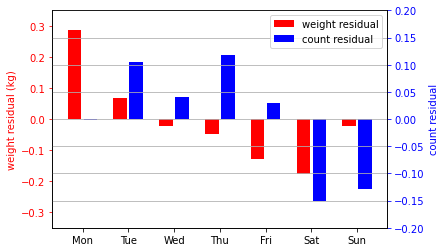

In [26]:
df_weekday_count = pd.merge(df_day[["YearWeek","DayOfWeek","count"]].rename(columns={"count":"count_day"}),
                        df_week[["YearWeek","count"]].rename(columns={"count":"count_week"}),
                        how='left',on="YearWeek",validate="m:1")
df_weekday_count["residual"] = df_weekday_count["count_day"] - df_weekday_count["count_week"]/7.
df_weekday_count=df_weekday_count[["DayOfWeek", "residual"]].groupby(["DayOfWeek"]).mean()
df_weekday_count=df_weekday_count.reset_index()
df["YearWeek"] = df["Year"].map('{:04}'.format) + "-" + df["Week"].map('{:02}'.format)
df_weekday_weight = pd.merge(df[["YearWeek","DayOfWeek","Weight"]],
                        df_week[["YearWeek","mean"]],
                        how='left',on="YearWeek",validate="m:1")
df_weekday_weight["residual"] = df_weekday_weight["Weight"] - df_weekday_weight["mean"]
df_weekday_weight=df_weekday_weight[["DayOfWeek", "residual"]].groupby(["DayOfWeek"]).mean()
df_weekday_weight=df_weekday_weight.reset_index()
width=0.35
fig, ax = plt.subplots()
ax2 = ax.twinx()
plot1 = ax.bar(df_weekday_weight["DayOfWeek"]-0.5*width,
    df_weekday_weight["residual"],
    width-0.05,
    color="r")
plot2 = ax2.bar(df_weekday_count["DayOfWeek"]+0.5*width,
    df_weekday_count["residual"],
    width-0.05,
    color="b")
ax.set_ylim(-0.35,0.35)
ax2.set_ylim(-0.2, 0.2)
ax.set_ylabel('weight residual (kg)')
ax2.set_ylabel('count residual')
ax.tick_params(axis='y', colors='red')
ax.yaxis.label.set_color('red')
ax2.tick_params(axis='y', colors='blue')
ax2.yaxis.label.set_color('blue')
plt.xlabel("")
plt.xticks(range(0,7),[calendar.day_name[x][0:3] for x in range(0,7)],rotation=0)
plt.legend((plot1,plot2),("weight residual","count residual"))
plt.grid(True)
plt.show()
pdf.savefig(fig)

In [27]:
df_weekday = pd.merge(df_weekday_weight[["DayOfWeek","residual"]].rename(columns={"residual":"res_weight"}).groupby(["DayOfWeek"]).mean(),
                        df_weekday_count[["DayOfWeek","residual"]].rename(columns={"residual":"res_count"}).groupby(["DayOfWeek"]).mean(),
                        on="DayOfWeek",validate="1:1")

In [28]:
model_wd = LinearRegression()
x = df_weekday.iloc[:, 0].values.reshape(-1, 1)
y = df_weekday.iloc[:, 1].values.reshape(-1, 1)
l = df_weekday.index
model_wd.fit(x,y)
fy = model_wd.predict(x)

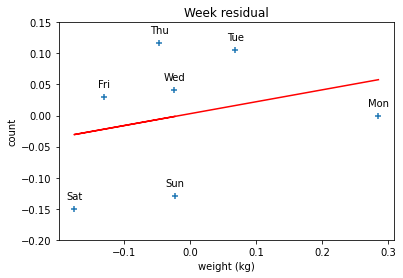

In [29]:
fig, ax = plt.subplots()
plt.scatter(x,y,marker="+")
plt.plot(x,fy,color='red')
plt.title("Week residual")
plt.ylabel("count")
plt.xlabel("weight (kg)")
plt.ylim(-0.2,0.15)
for xv,yv,lv in zip(x,y,l):
    plt.annotate(calendar.day_name[lv][0:3], # this is the text
                 (xv,yv), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()
pdf.savefig(fig)

In [30]:
df_weekday.corr(method='pearson')

,res_weight,res_count
res_weight,1.000000,0.274018
res_count,0.274018,1.000000


In [31]:
pdf.close()